In [1]:
import math
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import random

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
# from torchsummary import summary

# from pushover import notify
# from utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
# import torch.nn.functional as F
import torchvision.transforms.functional as FT

from file_manipulations import getSortedFramePaths
from vae_conv import VariationalAutoencoder, Encoder, Decoder

In [2]:
device = torch.device("cuda")

In [3]:
vae = VariationalAutoencoder().to(device)
vae.load_state_dict(torch.load('vae_conv.pth'))
vae.eval()

VariationalAutoencoder(
  (encoder): Encoder(
    (conv_1): Conv2d(1, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_2): Conv2d(2, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_3): Conv2d(4, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_4): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc_mu): Linear(in_features=512, out_features=256, bias=True)
    (fc_logvar): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): Decoder(
    (conv_trans_1): ConvTranspose2d(8, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_trans_2): ConvTranspose2d(4, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_trans_3): ConvTranspose2d(2, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (linear): Linear(in_features=256, out_features=512, bias=True)
    (sigmoid): Sigmoid()
  )
)

In [4]:
seq_len_x = 5
seq_len_y = 20
batch_size = 32
image_size = 64

In [5]:
image_path = "./Dance Data/SkeletonDataClean/Skeleton/Basic/"
composed_transform = torchvision.transforms.Compose([transforms.Resize(image_size), transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])

class DanceFrameDataset(Dataset):
    def __init__(self, image_path, transforms, seq_len_x, seq_len_y):
        self.transforms = transforms
        self.image_path = image_path
        self.seq_len_x = seq_len_x
        self.seq_len_y = seq_len_y
        self.image_names = getSortedFramePaths(self.image_path, ['gBR', 'gHO', 'gLH','gWA'])
    def __len__ (self):
            return len(self.image_names) - self.seq_len_x - self.seq_len_y
    def __getitem__(self, idx):
        image_locations = self.image_names[idx:idx+self.seq_len_x+self.seq_len_y]
        images = torch.empty(self.seq_len_x+self.seq_len_y, 256)
        i = 0
        with torch.no_grad():
            for image_location in image_locations:
                x = (self.transforms(Image.open(image_location)) > 0.5).float().view(1, 1, 64, 64)
                images[i] = vae.encoder(x.to(device))[0]
                i += 1
        

        return images[0:self.seq_len_x], images[self.seq_len_x:self.seq_len_x+self.seq_len_y]
    
frame_dataset = DanceFrameDataset(image_path, composed_transform, seq_len_x, seq_len_y)
frame_loader = DataLoader(dataset=frame_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [6]:
len(frame_loader)

1941

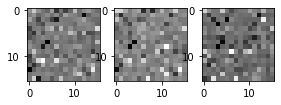

In [7]:
idx = 0

frames_x, frames_y = next(iter(frame_loader))
frames_x_dec = frames_y.to(device)
frames_x_dec = vae.decoder(frames_x_dec[idx])

for i in range(3):
    plt.subplot(1, 4, i+1)
    plt.imshow(frames_y[0][i].view(16, 16), cmap="gray")

In [8]:
frames_x.shape

torch.Size([32, 5, 256])

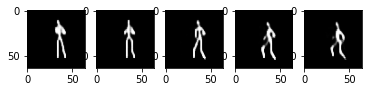

In [9]:
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(frames_x_dec[i].detach().cpu().view(64, 64), cmap="gray")

In [10]:
class Encoder(nn.Module):
    def __init__(self, num_features, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.dropout = nn.Dropout(p)
        
        self.rnn = nn.LSTM(num_features, hidden_size, num_layers, dropout=p, batch_first=True)
        
    def forward(self, x):
        # (seq_len, batch_size)
        
        outputs, (hidden, cell) = self.rnn(x)        
        
        return hidden, cell
        

In [11]:
class Decoder(nn.Module):
    def __init__ (self, num_features, hidden_size, num_layers, p):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.dropout = nn.Dropout(p)
        self.rnn = nn.LSTM(num_features, hidden_size, num_layers, dropout=p, batch_first=True)
        self.fc =  nn.Linear(hidden_size, num_features)
        
    def forward(self, x, hidden, cell):
        # x -> we want (1, N) -. one word at a time
#         x = x.unsqueeze(1)
        
        predictions, (hidden, cell) = self.rnn(x, (hidden, cell))

        predictions = self.fc(predictions)
#         predictions = predictions.squeeze(0)
        return predictions, hidden, cell

In [12]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, source, target, teacher_force_ratio, validation):
        batch_size = source.shape[0] #hmm 0
#         target_len = target.shape[1] # hmm 1
        target_len = seq_len_y
        
        
        hidden, cell = self.encoder(source)
        
#         x = target[:, 0, :]
        x = source[:, -1, :].unsqueeze(1)
        
        for t in range(target_len):
            output, hidden, cell= self.decoder(x, hidden, cell)
            
            if 'outputs' in locals():
                outputs = torch.cat((outputs, output), dim=1)
            else:
                outputs = output
            
            if validation == True:
                x = output
            else:
                x = target[:, t, :].unsqueeze(1) if random.random() < teacher_force_ratio else output
                
#             x = output
            
#             x = target[:, t, :]
        return outputs

In [19]:
num_epochs = 100
# learning_rate = 0.001
learning_rate = 0.001

num_features = 256
hidden_size = 2048 # hmm was 512
num_layers = 2
dropout = 0.8

loss_hist = []

In [20]:
encoder_net = Encoder(num_features, hidden_size, num_layers, dropout).to(device)
decoder_net = Decoder(num_features, hidden_size, num_layers, dropout).to(device)

model = Seq2Seq(encoder_net, decoder_net).to(device)

In [21]:
# batch, trg = next(iter(frame_loader))
# batch, trg = batch.to(device), trg.to(device)
# yhat = model(batch, trg, 0.5, True)

# from torchviz import make_dot
# make_dot(yhat, params=dict(list(model.named_parameters()))).render("seq_torchviz", format="png")

In [22]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True)

In [23]:
load_model = False

### chnged to p2 be careful

def save_checkpoint (state, file_name="seq2seq-teach-p2.pth.tar"):
    print('Saving Checkpoint')
    torch.save(state, file_name)
def load_checkpoint (checkpoint):
    print('Loading Checkpoint')
    model.load_state_dict(checkpoint['state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer'])

if load_model:
#     model.load_state_dict(torch.load('seq2seq-teach.pth.tar'))
    load_checkpoint(torch.load('seq2seq-teach.pth.tar'))

In [24]:
for epoch in range(num_epochs):
    checkpoint = {'state_dict': model.state_dict()}
    save_checkpoint(checkpoint)
    for idx, (source, target) in enumerate(frame_loader):
        optimizer.zero_grad()
        
        source, target = source.to(device), target.to(device)
        
        output = model(source, target, 0.15, False)
        
        loss1 = criterion(output[:, 0, :], target[:, 0, :])
        
        loss2 = criterion(output[:, 5, :], target[:, 5, :])
        
        loss3 = criterion(output[:, 10, :], target[:, 10, :])
        
        loss1 = criterion(output[:, 15, :], target[:, 15, :])
        
        loss4 = criterion(output[:, -1, :], target[:, -1, :])
        
        loss = loss1 + loss2 + loss3 + loss4

        loss_hist.append(loss.item())

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()
    
    
        if idx % 100 == 0:
            print(f'Epoch: {epoch} / {num_epochs} Batch:: {idx}/{len(frame_loader)} Loss: {loss}')
    mean_loss = sum(loss_hist)/len(loss_hist)
    scheduler.step(mean_loss)

Saving Checkpoint
Epoch: 0 / 100 Batch:: 0/1941 Loss: 1.301318883895874
Epoch: 0 / 100 Batch:: 100/1941 Loss: 1.3389101028442383
Epoch: 0 / 100 Batch:: 200/1941 Loss: 1.3083834648132324
Epoch: 0 / 100 Batch:: 300/1941 Loss: 1.3037174940109253
Epoch: 0 / 100 Batch:: 400/1941 Loss: 1.28902006149292
Epoch: 0 / 100 Batch:: 500/1941 Loss: 1.2360519170761108
Epoch: 0 / 100 Batch:: 600/1941 Loss: 1.2218788862228394
Epoch: 0 / 100 Batch:: 700/1941 Loss: 1.2822235822677612
Epoch: 0 / 100 Batch:: 800/1941 Loss: 1.1853055953979492
Epoch: 0 / 100 Batch:: 900/1941 Loss: 1.271877646446228
Epoch: 0 / 100 Batch:: 1000/1941 Loss: 1.226902723312378
Epoch: 0 / 100 Batch:: 1100/1941 Loss: 1.2121729850769043
Epoch: 0 / 100 Batch:: 1200/1941 Loss: 1.2239888906478882
Epoch: 0 / 100 Batch:: 1300/1941 Loss: 1.2568868398666382
Epoch: 0 / 100 Batch:: 1400/1941 Loss: 1.2722235918045044
Epoch: 0 / 100 Batch:: 1500/1941 Loss: 1.3273582458496094
Epoch: 0 / 100 Batch:: 1600/1941 Loss: 1.261323094367981
Epoch: 0 / 100

Epoch: 7 / 100 Batch:: 100/1941 Loss: 1.0434143543243408
Epoch: 7 / 100 Batch:: 200/1941 Loss: 1.1157889366149902
Epoch: 7 / 100 Batch:: 300/1941 Loss: 1.1004915237426758
Epoch: 7 / 100 Batch:: 400/1941 Loss: 1.1092572212219238
Epoch: 7 / 100 Batch:: 500/1941 Loss: 1.0425057411193848
Epoch: 7 / 100 Batch:: 600/1941 Loss: 1.1646466255187988
Epoch: 7 / 100 Batch:: 700/1941 Loss: 1.2260366678237915
Epoch: 7 / 100 Batch:: 800/1941 Loss: 1.0710195302963257
Epoch: 7 / 100 Batch:: 900/1941 Loss: 1.1834020614624023
Epoch: 7 / 100 Batch:: 1000/1941 Loss: 1.120373010635376
Epoch: 7 / 100 Batch:: 1100/1941 Loss: 1.0569682121276855
Epoch: 7 / 100 Batch:: 1200/1941 Loss: 1.0006213188171387
Epoch: 7 / 100 Batch:: 1300/1941 Loss: 1.0153629779815674
Epoch: 7 / 100 Batch:: 1400/1941 Loss: 1.0825778245925903
Epoch: 7 / 100 Batch:: 1500/1941 Loss: 1.0933082103729248
Epoch: 7 / 100 Batch:: 1600/1941 Loss: 1.0331523418426514
Epoch: 7 / 100 Batch:: 1700/1941 Loss: 1.1380524635314941
Epoch: 7 / 100 Batch:: 1

KeyboardInterrupt: 

In [ ]:
target.shape

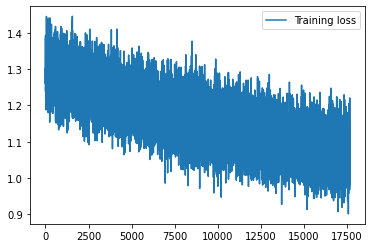

In [25]:
plt.plot(loss_hist, label="Training loss")
plt.legend()
plt.show()

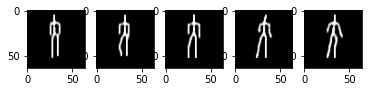

In [26]:
with torch.no_grad():
    img = vae.decoder(torch.squeeze(target[8])).detach().cpu()
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(img[i].view(64, 64), cmap="gray")

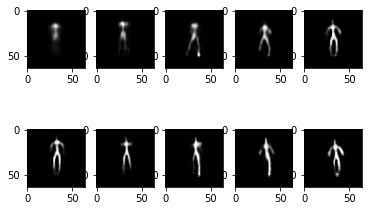

In [27]:
with torch.no_grad():
    img = vae.decoder(torch.squeeze(output[8])).detach().cpu()
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(img[i].view(64, 64), cmap="gray")

In [22]:
with torch.no_grad():
    img_trg = vae.decoder(torch.squeeze(target[8])).detach().cpu()
#     for i in range(seq_len_y):
#         plt.subplot(2, seq_len_y/2, i+1)
#         plt.imshow(img[i].view(64, 64), cmap="gray")

In [23]:
with torch.no_grad():
    img_pred = vae.decoder(torch.squeeze(output[8])).detach().cpu()
#     for i in range(seq_len_y):
#         plt.subplot(2, seq_len_y/2, i+1)
#         plt.imshow(img_pred[i].view(64, 64), cmap="gray")

In [38]:
torch.save(model.state_dict(), 'seq2seq-teach-2.pth')

In [39]:
img_x = vae.decoder(torch.squeeze(source[8])).detach().cpu()

for i in range(seq_len_x):
    image = img_x[i]
    image = FT.to_pil_image(image)
    image.save(f'generated/seq2seq/{i}.png')

In [28]:
for i in range(seq_len_y):
    image = img_pred[i]
    image = FT.to_pil_image(image)
    image.save(f'generated/seq2seq/y_{20+i}.png')

In [32]:
import cv2
import numpy as np
import glob
import os
from os.path import isfile, join
import re

def Images2Video (pathIn, pathOut, frameSize):

    # frameSize = (256, 256)
    # i = 3
    # pathIn = f'./generated/rnn/{i}/'
    # pathOut = f'video{i}.avi'

    files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
    files.sort(key=lambda f: int(re.sub('\D', '', f)))

    out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), 20, frameSize)
    print(files)
    for filename in files:
        img = cv2.imread(pathIn + filename)
        out.write(img)

    out.release()

In [30]:
Images2Video('generated/seq2seq/', 'generated/seq2seq/output.avi', (64, 64))

['0.png', '1.png', '2.png', '3.png', '4.png', 'y_20.png', 'y_21.png', 'y_22.png', 'y_23.png', 'y_24.png', 'y_25.png', 'y_26.png', 'y_27.png', 'y_28.png', 'y_29.png', 'y_30.png', 'y_31.png', 'y_32.png', 'y_33.png', 'y_34.png', 'y_35.png', 'y_36.png', 'y_37.png', 'y_38.png', 'y_39.png']


In [27]:
# image_names = getSortedFramePaths('./Dance Data/SkeletonDataClean/Skeleton/', ['Test'])

In [28]:
image_path = './Dance Data/SkeletonDataClean/Skeleton/'
composed_transform = torchvision.transforms.Compose([transforms.Resize(image_size), transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])

class DanceFrameDataset(Dataset):
    def __init__(self, image_path, transforms, seq_len_x, seq_len_y):
        self.transforms = transforms
        self.image_path = image_path
        self.seq_len_x = seq_len_x
        self.seq_len_y = seq_len_y
        self.image_names = getSortedFramePaths(self.image_path, ['Test'])
    def __len__ (self):
            return len(self.image_names) - self.seq_len_x - self.seq_len_y
    def __getitem__(self, idx):
        image_locations = self.image_names[idx:idx+self.seq_len_x+self.seq_len_y]
        images = torch.empty(self.seq_len_x+self.seq_len_y, 256)
        i = 0
        with torch.no_grad():
            for image_location in image_locations:
                x = (self.transforms(Image.open(image_location)) > 0.5).float().view(1, 1, 64, 64)
                images[i] = vae.encoder(x.to(device))[0]
                i += 1
        

        return images[0:self.seq_len_x], images[self.seq_len_x:self.seq_len_x+self.seq_len_y]
    
frame_dataset = DanceFrameDataset(image_path, composed_transform, seq_len_x, seq_len_y)
train_loader = DataLoader(dataset=frame_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [29]:
len(train_loader)

65

In [30]:
test_output_folder = './Dance Data/SkeletonDataClean/Skeleton/TestOutput/'
rnd = random.randint(0, 32)

In [34]:
with torch.no_grad():
    for idx, (source, target) in enumerate(train_loader):
        source, target = source.to(device), target.to(device)
        output = model(source, target, 0.3, True)
        output = vae.decoder(torch.squeeze(output[rnd]))
        folder_name = test_output_folder + str(idx)
        
        os.mkdir(folder_name)
        os.mkdir(folder_name + "/Pred/")
        os.mkdir(folder_name + "/Real/")
        
        img_x = vae.decoder(torch.squeeze(source[rnd])).detach().cpu()
        
        for i in range(seq_len_x):
            image = img_x[i]
            image = FT.to_pil_image(image)
            image.save(f'{folder_name}/Pred/{i}.png')
            
        output = output.cpu()
        for i in range(seq_len_y):
            image = output[i]
            image = FT.to_pil_image(image)
            image.save(f'{folder_name}/Pred/{20+i}.png')
            
        Images2Video(folder_name+"/Pred/", folder_name+'/Pred/output.avi', (64, 64))
        
        for i in range(seq_len_x):
            image = img_x[i]
            image = FT.to_pil_image(image)
            image.save(f'{folder_name}/Real/{i}.png')
        
        img_y = vae.decoder(torch.squeeze(target[rnd])).detach().cpu()
        for i in range(seq_len_y):
            image = img_y[i]
            image = FT.to_pil_image(image)
            image.save(f'{folder_name}/Real/{20+i}.png')
            
            
        Images2Video(folder_name+"/Real/", folder_name+'/Real/output.avi', (64, 64))
        
        

['0.png', '1.png', '2.png', '3.png', '4.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png']
['0.png', '1.png', '2.png', '3.png', '4.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png']
['0.png', '1.png', '2.png', '3.png', '4.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png']
['0.png', '1.png', '2.png', '3.png', '4.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png']
['0.png', '1.png

['0.png', '1.png', '2.png', '3.png', '4.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png']
['0.png', '1.png', '2.png', '3.png', '4.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png']
['0.png', '1.png', '2.png', '3.png', '4.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png']
['0.png', '1.png', '2.png', '3.png', '4.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png']
['0.png', '1.png

['0.png', '1.png', '2.png', '3.png', '4.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png']
['0.png', '1.png', '2.png', '3.png', '4.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png']
['0.png', '1.png', '2.png', '3.png', '4.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png']
['0.png', '1.png', '2.png', '3.png', '4.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png']
['0.png', '1.png

['0.png', '1.png', '2.png', '3.png', '4.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png']
['0.png', '1.png', '2.png', '3.png', '4.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png']
['0.png', '1.png', '2.png', '3.png', '4.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png']
['0.png', '1.png', '2.png', '3.png', '4.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png']
['0.png', '1.png

In [31]:
with torch.no_grad():
    pred = model(images_x, target, 0.5, True)
    pred = vae.decoder(torch.squeeze(pred))

In [32]:
pred = pred.cpu()

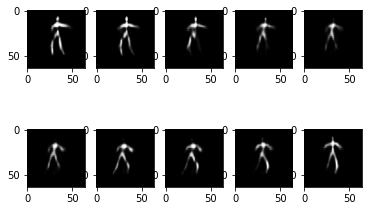

In [33]:
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(pred[i].view(64, 64), cmap="gray")

In [39]:
img_x = vae.decoder(torch.squeeze(images_x[0])).detach().cpu()

for i in range(seq_len_x):
    image = img_x[i]
    image = FT.to_pil_image(image)
    image.save(f'generated/seq2seq/{i}.png')

In [40]:
# img_x = vae.decoder(torch.squeeze(target[0])).detach().cpu()

# for i in range(seq_len_y):
#     image = img_x[i]
#     image = FT.to_pil_image(image)
#     image.save(f'generated/seq2seq/{20+i}.png')

In [35]:
for i in range(seq_len_y):
    image = pred[i]
    image = FT.to_pil_image(image)
    image.save(f'generated/seq2seq/{20+i}.png')

In [ ]:
# class RNNEncoder(nn.Module):
#     def __init__(self, rnn_num_layers=1, input_feature_len=256, sequence_len=5, hidden_size=256, bidirectional=False, device='cpu', rnn_dropout=0.2):
#         super().__init__()
#         self.sequence_len = sequence_len
#         self.hidden_size = hidden_size
#         self.input_feature_len = input_feature_len
#         self.num_layers = rnn_num_layers
#         self.rnn_directions = 2 if bidirectional else 1
#         self.gru = nn.GRU(
#             num_layers=rnn_num_layers,
#             input_size=input_feature_len,
#             hidden_size=hidden_size,
#             batch_first=True,
#             bidirectional=bidirectional,
#             dropout=rnn_dropout
#         )
#         self.device = device

#     def forward(self, input_seq):
#         ht = torch.zeros(self.num_layers * self.rnn_directions, input_seq.size(0), self.hidden_size, device=self.device)
#         if input_seq.ndim < 3:
#             input_seq.unsqueeze_(2)
#         gru_out, hidden = self.gru(input_seq, ht)
#         print(gru_out.shape)
#         print(hidden.shape)
#         if self.rnn_directions * self.num_layers > 1:
#             num_layers = self.rnn_directions * self.num_layers
#             if self.rnn_directions > 1:
#                 gru_out = gru_out.view(input_seq.size(0), self.sequence_len, self.rnn_directions, self.hidden_size)
#                 gru_out = torch.sum(gru_out, axis=2)
#             hidden = hidden.view(self.num_layers, self.rnn_directions, input_seq.size(0), self.hidden_size)
#             if self.num_layers > 0:
#                 hidden = hidden[-1]
#             else:
#                 hidden = hidden.squeeze(0)
#             hidden = hidden.sum(axis=0)
#         else:
#             hidden.squeeze_(0)
#         return gru_out, hidden


In [31]:
# class DecoderCell(nn.Module):
#     def __init__(self, input_feature_len, hidden_size, dropout=0.2):
#         super().__init__()
#         self.decoder_rnn_cell = nn.GRUCell(
#             input_size=input_feature_len,
#             hidden_size=hidden_size,
#         )
#         self.out = nn.Linear(hidden_size, 1)
#         self.attention = False
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, prev_hidden, y):
#         rnn_hidden = self.decoder_rnn_cell(y, prev_hidden)
#         output = self.out(rnn_hidden)
#         return output, self.dropout(rnn_hidden)

In [32]:
# class EncoderDecoderWrapper(nn.Module):
#     def __init__(self, encoder, decoder_cell, output_size=5, teacher_forcing=0.3, sequence_len=336, decoder_input=True, device='cpu'):
#         super().__init__()
#         self.encoder = encoder
#         self.decoder_cell = decoder_cell
#         self.output_size = output_size
#         self.teacher_forcing = teacher_forcing
# #         self.sequence_length = sequence_len
#         self.decoder_input = decoder_input
#         self.device = device

#     def forward(self, xb, yb=None):
#         if self.decoder_input:
#             decoder_input = xb[-1]
#             input_seq = xb[0]
#             if len(xb) > 2:
#                 encoder_output, encoder_hidden = self.encoder(input_seq, *xb[1:-1])
#             else:
#                 encoder_output, encoder_hidden = self.encoder(input_seq)
#         else:
#             if type(xb) is list and len(xb) > 1:
#                 input_seq = xb[0]
#                 encoder_output, encoder_hidden = self.encoder(*xb)
#             else:
#                 input_seq = xb
#                 encoder_output, encoder_hidden = self.encoder(input_seq)
#         prev_hidden = encoder_hidden
#         outputs = torch.zeros(input_seq.size(0), self.output_size, device=self.device)
#         y_prev = input_seq[:, -1, 0].unsqueeze(1)
#         for i in range(self.output_size):
#             step_decoder_input = torch.cat((y_prev, decoder_input[:, i]), axis=1)
#             if (yb is not None) and (i > 0) and (torch.rand(1) < self.teacher_forcing):
#                 step_decoder_input = torch.cat((yb[:, i].unsqueeze(1), decoder_input[:, i]), axis=1)
#             rnn_output, prev_hidden = self.decoder_cell(prev_hidden, step_decoder_input)
#             y_prev = rnn_output
#             outputs[:, i] = rnn_output.squeeze(1)
#         return outputs

In [33]:
model = EncoderDecoderWrapper(RNNEncoder(), DecoderCell(256, 256)).to(device)

In [34]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True)

In [35]:
num_epochs = 100
loss_hist = []

In [36]:
for epoch in range(num_epochs):
    for idx, (latents) in enumerate(frame_loader):
        model.zero_grad()
        
        latents_x,  latents_y = latents[:, 0:seq_len, :].to(device), latents[:, seq_len:seq_len+seq_len, :].to(device)
        

        
        prediction = model(latents_x)
        
        print(prediction.shape)
        
        
    
        
        
#         pred_y = vae.decoder(prediction[:, seq_len-1, :])
        
#         loss = criterion(pred_y, y)
        
#         loss_hist.append(loss.item())
        
#         loss.backward()


        optimizer.step()
        
        if idx % 100 == 0:
            print(f'Epoch: {epoch} / {num_epochs} Batch:: {idx}/{len(frame_loader)} Loss: {loss}')
    
    mean_loss = sum(loss_hist)/len(loss_hist)
    scheduler.step(mean_loss)

RuntimeError: input.size(-1) must be equal to input_size. Expected 256, got 1

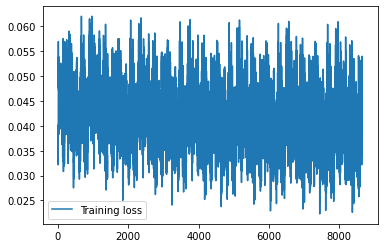

In [50]:
plt.plot(loss_hist, label="Training loss")
plt.legend()
plt.show()

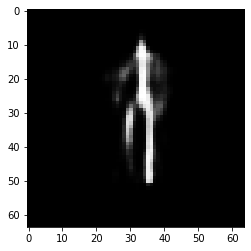

In [53]:
plt.imshow(pred_y[3].detach().cpu().view(64, 64), cmap="gray")

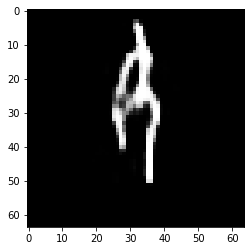

In [54]:
plt.imshow(y[3].cpu().view(64, 64), cmap="gray")

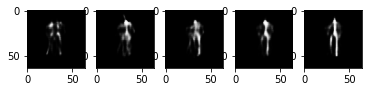

In [56]:
with torch.no_grad():
    img = vae.decoder(torch.squeeze(prediction[3])).detach().cpu()
    for i in range(seq_len):
        plt.subplot(1, 5, i+1)
        plt.imshow(img[i].view(64, 64), cmap="gray")